In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

## 1 A Simplified Decision Tree

In [ ]:
class Node:
    def __init__(self, feature_index = None, threshold = None, value = None, left = None, right = None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold  # Threshold value for the split
        self.value = value  # Class label for leaf nodes
        self.left = left  # Left subtree
        self.right = right  # Right subtree

class DecisionTree:
    def __init__(self):
        self.root = None  # Root node of the tree

    def fit(self, X, y):
        self.root = self._fit(X, y)

    def _fit(self, X, y):
        # Termination conditions
        if (len(y) == 1) or np.all(y == y[0]):
            return Node(value = self._most_common_class(y))
        
        # Find the best split using IGR
        feature_index, threshold = self._best_split(X, y)

        # Termination condition if no split improves impurity
        if feature_index is None:
            return Node(value = self._most_common_class(y))

        # Recursive splitting
        left_mask = X[:, feature_index] >= threshold
        right_mask = ~left_mask
        left_subtree = self._fit(X[left_mask], y[left_mask])
        right_subtree = self._fit(X[right_mask], y[right_mask])

        return Node(feature_index, threshold, left = left_subtree, right = right_subtree)

    def _most_common_class(self, y):
        if np.sum(y == 0) <= np.sum(y == 1): 
            return 1
        else: 
            return 0

    def _compute_entropy(self, y):
        y0 = np.sum(y == 0) # number of Label 0
        y1 = np.sum(y == 1) # number of Label 1
        n = len(y) # number of labels
        if (y0 == 0) or (y1 == 0): # only one kind
            return 0
        else:
            p = np.array([y0, y1]) / n
            return -np.sum(p * np.log2(p))

    def _compute_igr(self, y, left_y, right_y):
        # Information Gain Ratio (IGR) computation
        H_y = self._compute_entropy(y)
        H_left = self._compute_entropy(left_y)
        H_right = self._compute_entropy(right_y)
        p = np.array([len(left_y), len(right_y)]) / len(y)
        H_y_given_x = p[0] * H_left + p[1] * H_right
        Hs = -np.sum(p * np.log2(p))
        IGR = (H_y - H_y_given_x) / Hs
        return IGR

    def _best_split(self, X, y):
        best_feature_index = None
        best_threshold = None
        best_igr = 0

        for feature_index in range(X.shape[1]):
            unique_values = np.unique(X[:, feature_index])
            for threshold in unique_values:
                left_mask = X[:, feature_index] >= threshold
                right_mask = ~left_mask
                left_y = y[left_mask]
                right_y = y[right_mask]
                
                if len(left_y) > 0 and len(right_y) > 0:
                    igr = self._compute_igr(y, left_y, right_y)
                    if igr > best_igr:
                        best_feature_index = feature_index
                        best_threshold = threshold
                        best_igr = igr
        
        return best_feature_index, best_threshold

    def predict(self, X):
        return np.array([self._predict_tree(x, self.root) for x in X])

    def _predict_tree(self, x, node):
        if node.value is not None:
            return node.value
        elif x[node.feature_index] >= node.threshold:
            return self._predict_tree(x, node.left)
        else:
            return self._predict_tree(x, node.right)
        
    def visualization(self):
        def recursive_visualization(node, depth = 0):
            indent = "  " * depth
            if node.value is not None:
                print(indent + f"Label {node.value}")
            else:
                print(indent + f"if x{node.feature_index + 1} >= {node.threshold}:")
                recursive_visualization(node.left, depth + 1)
                print(indent + "else:")
                recursive_visualization(node.right, depth + 1)
        recursive_visualization(self.root)

    def decision_boundary(self, X, y, title): 
        xx, yy = np.meshgrid(np.arange(min(X[:, 0]) - 0.1, max(X[:, 0]) + 0.1, 0.005), 
                     np.arange(min(X[:, 1]) - 0.1, max(X[:, 1]) + 0.1, 0.005))

        # Make predictions for all points in the meshgrid
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        fig, ax = plt.subplots(figsize = (5, 5))
        ax.scatter(X[y == 0, 0], X[y == 0, 1], s = 5, label = 'Label 0')
        ax.scatter(X[y == 1, 0], X[y == 1, 1], s = 5, label = 'Label 1')
        ax.contourf(xx, yy, Z, cmap = 'cividis', alpha = 0.25)
        ax.set_xlabel(r'$x_1$')
        ax.set_ylabel(r'$x_2$')
        ax.legend()
        ax.set_title(title)

        plt.show()

    def nodes_number(self): 
        def recursive_nodes_number(node): 
            if node is None: 
                return 0
            else:
                return 1 + recursive_nodes_number(node.left) + recursive_nodes_number(node.right)
        return recursive_nodes_number(self.root)

## 2 Questions
### 2.2

In [ ]:
x0 = [1,2]
y0 = [1,2]
x1 = [1,2]
y1 = [2,1]
fig, ax = plt.subplots(figsize = (5, 5))
ax.scatter(x0, y0, label = '0')
ax.scatter(x1, y1, label = '1')
ax.legend()
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title('Training Set for Q2')
plt.show()

### 2.3

In [ ]:
def entropy_labels(y): # calculate the entropy of labels
    y0 = np.sum(y == 0) # number of Label 0
    y1 = np.sum(y == 1) # number of Label 1
    n = len(y) # number of labels
    if (y0 == 0) or (y1 == 0): # only one kind
        return 0
    else:
        p = np.array([y0, y1]) / n
        return -np.sum(p * np.log2(p))

# Read the data set
Druns = np.loadtxt("./Data/Druns.txt") # possibly need to edit the directory
X = Druns[:, :-1] # feature values
n = X.shape[0] # number of items
Y = Druns[:, -1] # labels

Hy = entropy_labels(Y) # entropy of labels

# Create a data frame for storing results
results = pd.DataFrame(columns = ["Feature", "Threshold", "IG", "IGR"])

for i in range(X.shape[1]): # loops of different features
    val = X[:, i] # values of Feature i
    thres = set(val) # thresholds of splits
    
    for c in thres: # loops of different splits
        l = (val >= c) # items of the left branch
        prop_l = np.sum(l) / n # proportion of the left branch
        prop_r = 1 - prop_l # proportion of the right branch
        if (prop_l == 0 or prop_r == 0): # if the entropy of the candidate split is zero
            # The IG must be zero since one of the two branches has zero item.
            results.loc[len(results.index)] = [i+1, c, 0, "NA"]
        else:
            Hs = -prop_l * np.log2(prop_l) - prop_r * np.log2(prop_r) # entropy of split
            Yl = Y[l] # labels of the left branch
            Yr = Y[~l] # labels of the right branch
            IG = Hy - prop_l * entropy_labels(Yl) - prop_r * entropy_labels(Yr) # information gain
            IGR = IG / Hs # information gain ratio
            results.loc[len(results.index)] = [i+1, c, IG, IGR]

results["Feature"] = results["Feature"].astype(int)
display(results)

### 2.4

In [ ]:
D3leaves = np.loadtxt("./Data/D3leaves.txt") # possibly need to edit the directory
X = D3leaves[:, :-1]
Y = D3leaves[:, -1]
DT = DecisionTree()
DT.fit(X, Y)
DT.visualization()

In [ ]:
tree = graphviz.Digraph(format = 'png')

tree.node('A', "x1 >= 10")
tree.node('B', 'Label 1')
tree.node('C', "x1 >= 3")
tree.node('D', 'Label 1')
tree.node('E', 'Label 0')

tree.edges(['AB', 'AC', "CD", "CE"])

tree.render()

### 2.5.1

In [ ]:
D1 = np.loadtxt("./Data/D1.txt") # possibly need to edit the directory
X = D1[:, :-1]
Y = D1[:, -1]
DT1 = DecisionTree()
DT1.fit(X, Y)
DT1.visualization()

In [ ]:
tree = graphviz.Digraph(format = 'png')

tree.node('A', "x2 >= 0.201829")
tree.node('B', 'Label 1')
tree.node('C', "Label 0")

tree.edges(['AB', 'AC'])

tree.render()

### 2.5.3

In [ ]:
D2 = np.loadtxt("./Data/D2.txt") # possibly need to edit the directory
X = D2[:, :-1]
Y = D2[:, -1]
DT2 = DecisionTree()
DT2.fit(X, Y)
DT2.visualization()

In [ ]:
tree = graphviz.Digraph(format = 'png')

nodes = {
    'N1': ['x1 >= 0.53'], 
    'N2': ['x2 >= 0.23', 'x2 >= 0.89'], 
    'N3': ['x2 >= 0.42', 'x1 >= 0.89', 'x1 >= 0.04', 'x1 >= 0.69'], 
    'N4': ['Label 1', 'x1 >= 0.71', 'x2 >= 0.04', 'x1 >= 0.85', 'x1 >= 0.10', 'Label 0', 'x1 >= 0.25', 'x2 >= 0.53'], 
    'N5': ['Label 1', 'x2 >= 0.33', 'x2 >= 0.08', 'Label 0', "x2 >= 0.17", 'Label 0', 'Label 1', 'x1 >= 0.08', 'Label 1', 'x1 >= 0.19', 'x1 >= 0.43', 'Label 0'], 
    'N6': ['x1 >= 0.60', 'Label 0', 'Label 1', 'x1 >= 0.96', 'Label 1', 'Label 0', 'Label 0', 'Label 1', 'x2 >= 0.79', 'x2 >= 0.86', 'Label 1', 'x1 >= 0.41'], 
    'N7': ['x1 >= 0.65', 'Label 0', 'Label 1', 'Label 0', 'Label 1', 'Label 0', 'x1 >= 0.14', 'Label 0', 'x1 >= 0.42', 'x1 >= 0.39'], 
    'N8': ['Label 1', 'x2 >= 0.40', 'Label 1', 'Label 0', 'Label 0', 'Label 1', 'x1 >= 0.40', 'Label 0'], 
    'N9': ['Label 1', 'Label 0', 'Label 0', 'Label 1']
}

edges = {
    'E1': [[0,0], [0,1]], 
    'E2': [[0,0], [0,1], [1,2], [1,3]], 
    'E3': [[0,0], [0,1], [1,2], 
           [1,3], 
           [2,4], 
           [2,5], 
           [3,6], 
           [3,7]], 
    'E4': [[1,0], 
           [1,1], 
           [2,2], 
           [2,3], 
           [3,4], 
           [3,5], 
           [4,6], 
           [4,7], 
           [5,8], 
           [5,9], 
           [6,10], 
           [6,11]], 
    'E5': [[1,0], 
           [1,1], 
           [2,2], 
           [2,3], 
           [4,4], 
           [4,5], 
           [7,6], 
           [7,7], 
           [9,8], 
           [9,9], 
           [10,10], 
           [10,11]], 
    'E6': [[0,0], 
           [0,1], 
           [3,2], 
           [3,3], 
           [8,4], 
           [8,5], 
           [9,6], 
           [9,7], 
           [11,8], 
           [11,9]], 
    'E7': [[0,0], 
           [0,1], 
           [6,2], 
           [6,3], 
           [8,4], 
           [8,5], 
           [9,6], 
           [9,7]], 
    'E8': [[1,0], 
           [1,1], 
           [6,2], 
           [6,3]]
}

for i in range(1, 10):
    for j in range(len(nodes['N{}'.format(i)])): 
        tree.node('N{}{}'.format(i, j), nodes['N{}'.format(i)][j])

for i in range(1, 9): 
    for j in range(len(edges['E{}'.format(i)])): 
        tree.edge('N{}{}'.format(i, edges['E{}'.format(i)][j][0]), 
                  'N{}{}'.format(i+1, edges['E{}'.format(i)][j][1]))

tree.render()

### 2.6 Hypothesis space

In [ ]:
X = D1[:, :-1]
Y = D1[:, -1]

fig, ax = plt.subplots(figsize = (5, 5))
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], s = 5, label = 'Label 0')
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], s = 5, label = 'Label 1')
ax.axhline(y = DT1.root.threshold, color = 'black', label = 'boundary')
ax.legend(loc = 'upper right')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title('D1 with Decision Boundary')
plt.show()

In [ ]:
X = D2[:, :-1]
Y = D2[:, -1]

DT2.decision_boundary(X, Y, 'D2 with Decision Boundary')

### 2.7 Learning curve

In [ ]:
np.random.seed(760)

Dbig = np.loadtxt('./Data/Dbig.txt')

perm = np.random.choice(np.arange(Dbig.shape[0]), size = Dbig.shape[0], replace = False)

# training set
X_train = Dbig[perm[:8192], :-1]
Y_train = Dbig[perm[:8192], -1]

# test set
X_test = Dbig[perm[8192:], :-1]
Y_test = Dbig[perm[8192:], -1]

nest = [32, 128, 512, 2048, 8192]

nodes = np.zeros(len(nest), dtype = int)
error = np.zeros(len(nest))

for i in range(len(nest)):
    n = nest[i]
    X = Dbig[perm[:n], :-1]
    Y = Dbig[perm[:n], -1]
    
    DT = DecisionTree()
    DT.fit(X, Y)
    # DT.decision_boundary(X, Y, title = 'Decision Boundary: n = {}'.format(n))
    pred = DT.predict(X_test)
    num = DT.nodes_number()
    err = np.sum(pred != Y_test) / len(Y_test)
    
    nodes[i] = num
    error[i] = err

In [ ]:
nodes_error = pd.DataFrame({
    'size': nest, 
    'nodes': nodes, 
    'error': error
})
display(nodes_error)

In [ ]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(nest, error)
ax.set_xlabel('training set size')
ax.set_ylabel('test set error')
ax.set_title('Learning curve')
plt.show()

## 3 sklearn

In [ ]:
from sklearn.tree import DecisionTreeClassifier

nodes = np.zeros(len(nest), dtype = int)
error = np.zeros(len(nest))
for i in range(len(nest)):
    n = nest[i]
    X = Dbig[perm[:n], :-1]
    Y = Dbig[perm[:n], -1]
    
    DT = DecisionTreeClassifier()
    DT.fit(X, Y)
    pred = DT.predict(X_test)
    num = DT.tree_.node_count
    err = np.sum(pred != Y_test) / len(Y_test)
    
    nodes[i] = num
    error[i] = err

nodes_error = pd.DataFrame({
    'size': nest, 
    'nodes': nodes, 
    'error': error
})
display(nodes_error)

fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(nest, error)
ax.set_xlabel('training set size')
ax.set_ylabel('test set error')
ax.set_title('Learning curve')
plt.show()

## 4 Lagrange Interpolation

No Noise
Train error: 172.83051206425236
Test error: 170.4547769939692


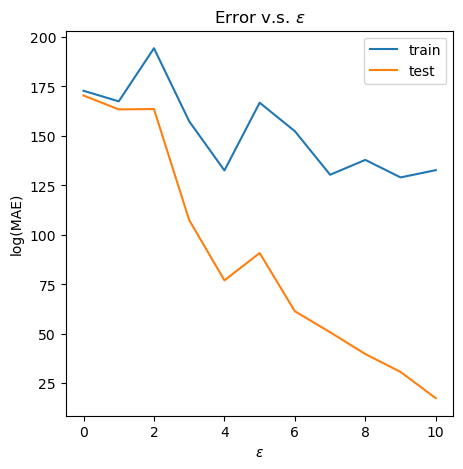

In [112]:
from scipy.interpolate import lagrange

np.random.seed(760)

a, b = 0, 2 * np.pi
n = 100

x_train = np.random.uniform(a, b, n)
y_train = np.sin(x_train)

x_test = np.random.uniform(a, b, n)
y_test = np.sin(x_test)

poly = lagrange(x_train, y_train)

# log of mean absolute error
train_error = np.log(np.sum(np.abs(y_train - poly(x_train))) / n)
test_error = np.log(np.sum(np.abs(y_test - poly(x_test))) / n)

print("No Noise")
print("Train error:", train_error)
print("Test error:", test_error)

sd = np.arange(1, 11) # standard deviations of gaussian noise

train_errors = np.zeros(len(sd) + 1)
test_errors = np.zeros(len(sd) + 1)
train_errors[0] = train_error
test_errors[0] = test_error

for i in range(len(sd)):
    x_train_noise = x_train + np.random.normal(0, sd[i], n)
    y_train_noise = np.sin(x_train_noise)

    poly = lagrange(x_train_noise, y_train_noise)

    # log of mean absolute error
    train_error = np.log(np.sum(np.abs(y_train_noise - poly(x_train_noise))) / n)
    test_error = np.log(np.sum(np.abs(y_test - poly(x_test))) / n)
    train_errors[i+1] = train_error
    test_errors[i+1] = test_error

    # print(f"\nε = {eps}")
    # print("Train error with noise:", train_error)
    # print("Test error with noise:", test_error)

fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(np.concatenate(([0], sd)), train_errors, label = "train")
ax.plot(np.concatenate(([0], sd)), test_errors, label = "test")
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log(MAE)')
ax.legend()
ax.set_title(r'Error v.s. $\epsilon$')
plt.show()